**Exploring World Cup Data: Kiran Singh & Sowmya Murali**
======
***

# Table of Contents

## Part 1: Reading and Merging Data Sources
## Part 2: Explore Data
    1 Average Age of Teams
    2 BMI and Height by Position
    3 Loyalty of Players (Country Team vs Club Team)
    4 Map wins on world map
## Part 3: Next Steps

# Part 1: Reading and Merging Data Sources
***

### Data sources:
+ https://www.kaggle.com/djamshed/fifa-world-cup-2018-players
+ https://www.kaggle.com/abecklas/fifa-world-cup#WorldCups.csv
+ https://en.wikipedia.org/wiki/List_of_FIFA_country_codes

### Import Modules

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

### Reading csvs

In [2]:
WorldCup2018Players = '/Users/sowmyamurali/Documents/DataViz/wc2018-players.csv'
WorldCupResults = '/Users/sowmyamurali/Documents/DataViz/WorldCups.csv'
WorldCupCountryCodes = '/Users/sowmyamurali/Documents/DataViz/country codes.csv'

LoyaltyHeatmap = '/Users/sowmyamurali/Documents/DataViz/output.png'

### Replace blanks

In [3]:
df_wcplayers = pd.read_csv(WorldCup2018Players)
df_wcplayers.columns = df_wcplayers.columns.str.replace(' ', '_')
df_wcplayers.columns = df_wcplayers.columns.str.replace('.', '')

### Descriptive Position names

In [4]:
df_wcplayers.loc[df_wcplayers['Pos'] == 'DF','Pos'] = 'defender'
df_wcplayers.loc[df_wcplayers['Pos'] == 'MF','Pos'] = 'midfielder'
df_wcplayers.loc[df_wcplayers['Pos'] == 'FW','Pos'] = 'forward'
df_wcplayers.loc[df_wcplayers['Pos'] == 'GK','Pos'] = 'goalkeeper'

### Fix Country Names

In [5]:
df_wcplayers['Team'].unique()

array(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Colombia',
       'Costa Rica', 'Croatia', 'Denmark', 'Egypt', 'England', 'France',
       'Germany', 'Iceland', 'IR Iran', 'Japan', 'Korea Republic',
       'Mexico', 'Morocco', 'Nigeria', 'Panama', 'Peru', 'Poland',
       'Portugal', 'Russia', 'Saudi Arabia', 'Senegal', 'Serbia', 'Spain',
       'Sweden', 'Switzerland', 'Tunisia', 'Uruguay'], dtype=object)

In [6]:
df_wcplayers.loc[df_wcplayers['Team'] == 'IR Iran', 'Team'] = 'Iran'
df_wcplayers.loc[df_wcplayers['Team'] == 'Korea Republic', 'Team'] = 'South Korea'

### Extract the club code

In [7]:
df_wcplayers['clubCode'] = df_wcplayers['Club'].str[-5:]
df_wcplayers['clubCode'] = df_wcplayers['clubCode'].str[1:4]

### Get corresponging country names for the club codes

In [8]:
colnames = ['Code', 'Country']
codes = pd.read_csv(WorldCupCountryCodes, header=0, names=colnames)

code = codes.Code.tolist()
country = codes.Country.tolist()
l = {code[i]:country[i] for i in range(211)}

df_wcplayers['clubCountry'] = df_wcplayers.clubCode.map(l)

### Convert 'Country' to string

In [9]:
df_wcplayers['Team'] = df_wcplayers['Team'].astype(str)
df_wcplayers['clubCountry'] = df_wcplayers['clubCountry'].astype(str)
df_wcplayers['clubCountry'] = df_wcplayers['clubCountry'].str.strip()

### Generate a 'Loyal' variable
Loyal = if the player plays for the same country as the country their club team is based in

In [10]:
df_wcplayers['Loyal'] = False
df_wcplayers.loc[df_wcplayers['clubCountry'] == df_wcplayers['Team'], 'Loyal'] = True

### Generate age of each player

In [11]:
df_wcplayers['Birth_Date'] = pd.to_datetime(df_wcplayers.Birth_Date).dt.strftime('%m/%d/%Y')
df_wcplayers['today'] = datetime.today().strftime("%m/%d/%Y")
df_wcplayers['Birth_Date'] = pd.to_datetime(df_wcplayers.Birth_Date)
df_wcplayers['today'] = pd.to_datetime(df_wcplayers.today)
df_wcplayers['age'] = (df_wcplayers['today'] - df_wcplayers['Birth_Date'])/ timedelta (days=365)
df_wcplayers['age'] = round(df_wcplayers['age'], 0)

### Generate BMI of each player
BMI: divide your weight in kilograms (kg) by your height in metres (m) then divide the answer by your height again

In [12]:
df_wcplayers['bmi'] = df_wcplayers['Weight']/(df_wcplayers['Height']/100)**2
df_wcplayers['bmi'] = df_wcplayers.bmi.astype(int)

### Drop unused columns

In [13]:
df_wcplayers = df_wcplayers.drop(['today', 'Shirt_Name'], axis=1)

### Get historical number of World Cup wins

In [14]:
df_wc = pd.read_csv(WorldCupResults)

rules = {'Germany FR':'Germany'}
df_wc['Winner'].replace(rules, inplace=True)
winner = df_wc.groupby('Winner').count()
winner['Winner'] = winner.index
winner = winner[['Winner', 'Year']]
winner = winner.rename(index=str, columns={"Year": "Num_Wins"})

### Get # of World Cup 2nd place

In [15]:
rules = {'Germany FR':'Germany'}
df_wc['Runners-Up'].replace(rules, inplace=True)
runnerUp = df_wc.groupby('Runners-Up').count()
runnerUp['Runners-Up'] = runnerUp.index
runnerUp = runnerUp[['Runners-Up', 'Year']]
runnerUp = runnerUp.rename(index=str, columns={"Year": "Num_2nd"})

### Get # of World Cup 3rd place

In [16]:
rules = {'Germany FR':'Germany'}
df_wc['Third'].replace(rules, inplace=True)
third = df_wc.groupby('Third').count()
third['Third'] = third.index
third = third[['Third', 'Year']]
third = third.rename(index=str, columns={"Year": "Num_3rd"})

### Merge the datasets

In [17]:
df_country = df_wcplayers.Team.drop_duplicates()
df_country = pd.DataFrame(data=df_country)

df_stats = pd.merge(df_country, winner, left_on='Team', right_on='Winner', how='left')
df_stats = pd.merge(df_stats, runnerUp, left_on='Team', right_on='Runners-Up', how='left')
df_stats = pd.merge(df_stats, third, left_on='Team', right_on='Third', how='left')
df_stats = df_stats.drop(['Winner', 'Runners-Up', 'Third'], axis=1)
df_stats = df_stats.replace(np.nan, '0')

### Final dataset

In [18]:
df = pd.merge(df_wcplayers, df_stats, on='Team', how='left')

# Part 2: Explore the data 
***

## 1. Average age of each team

### Average overall age

In [19]:
df['age'].mean()

27.994565217391305

### Averages of each team

In [32]:
df_avg = df.groupby(['Team']).mean().round(2)
df_avg['Team'] = df_avg.index

In [43]:
y = np.array(df_avg['age'])
color = np.array(['#7F055F']*y.shape[0], dtype='U24')
color[y>=28] = '#45062E'

### Plot the average age of each team

In [44]:
layout = go.Layout(
            autosize = False,
            width = 950,
            height = 800,
            margin = dict(
                l = 140,
                r = 25,
                b = 60,
                t = 60,
                pad = 3),
            title = 'Average Age of Teams in the 2018 World Cup',
            titlefont = dict(size=26),
            xaxis = dict(
                title = 'Average age (years)',
                titlefont = dict(size=22),
                tickfont = dict(size=16),
                ticks = 'outside',
                tickcolor = '#45062E',
                tickwidth = 2,
                ticklen = 10,
                range = [25, 30]),
            yaxis = dict(
                title = 'Country',
                titlefont = dict(size=22),
                tickfont = dict(size=14)),
            annotations=[dict(
                    x = 28,
                    y = 32,
                    xref = 'x',
                    yref = 'y',
                    text = 'Average Overall Age',
                    font = dict(size = 16),
                    showarrow = True,
                    arrowcolor = '#7F055F',
                    arrowsize = 0.3,
                    arrowwidth = 3,
                    arrowhead = 7,
                    ax = 1,
                    ay = -10)],
            shapes = [dict(
                type = 'line',
                layer = 'above',
                x0 = 28,
                x1 = 28,
                y0 = -1,
                y1 = 32,
                line = dict(
                       color = '#45062E',
                       width = 2.75,
                       dash = 'dash'))])   

data = [go.Bar(
        x = df_avg['age'],
        y = df_avg['Team'],
        width = .85,
        marker = dict(color=color.tolist()),
        orientation = 'h',
        showlegend = False)]

fig = go.Figure(data = data, layout = layout)
iplot(fig, filename = 'Age by Team')

### Insights
+ The green line corresponds to the average age of all players in the world cup
+ All teams' have an average age range between 25 and 29
+ All of the final 4 teams (England, Belgium, Croatia, and France) are young (below the average age)
+ France, the winner, was the youngest team

## 2. BMI and Height by Position

### Plot BMI by Position

In [22]:
x_data = ['Forward', 'Midfielder',
          'Goal Keeper', 'Defender']

y0 = df[df['Pos'] == 'forward']['bmi']
y1 = df[df['Pos'] == 'midfielder']['bmi']
y2 = df[df['Pos'] == 'goalkeeper']['bmi']
y3 = df[df['Pos'] == 'defender']['bmi']

y_data = [y0, y1, y2, y3]

colors = ['#E55381', '#A5402D', '#404E5C', '#60D394']

traces = []

for xd, yd, cls in zip(x_data, y_data, colors):
        traces.append(go.Box(
            y = yd,
            name = xd,
            boxpoints = 'all',
            jitter = 0.4,
            pointpos = 0,
            whiskerwidth = 0.5,
            marker = dict(size=3),
            line = dict(width=1)))

layout = go.Layout(
        title = 'BMI by Position of Players at the 2018 World Cup',
        titlefont = dict(size=22),
        xaxis = dict(
            title = 'Position',
            titlefont = dict(size=16)),    
        yaxis = dict(
            title = 'BMI',
            titlefont = dict(size=16),
            autorange = True,
            showgrid = True,
            zeroline = True,
            dtick = 2,
            gridcolor = '#BBC7A4',
            gridwidth = 1,
            zerolinecolor = '#BBC7A4',
            zerolinewidth = 3),
        margin = dict(
            l = 40,
            r = 30,
            b = 80,
            t = 100),
        showlegend=False)

fig = go.Figure(data=traces, layout=layout)
iplot(fig, filename = 'BMI by Position')

### Insights
+ A healthy BMI for males is between 18.5-24.9; Most players are very healthy
+ BMI  fairly similar across all positions
+ Midfielders have the lowest BMI, makes sense as this postion requires the most running

### Convert height to feet
To convert metres to feet, multiply by 0.03280841666667

In [23]:
df['height_ft'] = df.Height*0.03280841666667
df['height_ft']= df['height_ft'].round(2)

### Plot Height by Position

In [24]:
x_data = ['Forward', 'Midfielder',
          'Goal Keeper', 'Defender']

y0 = df[df['Pos'] == 'forward']['height_ft']
y1 = df[df['Pos'] == 'midfielder']['height_ft']
y2 = df[df['Pos'] == 'goalkeeper']['height_ft']
y3 = df[df['Pos'] == 'defender']['height_ft']

y_data = [y0, y1, y2, y3]

colors = ['#E55381', '#A5402D', '#404E5C', '#60D394']

traces = []

for xd, yd, cls in zip(x_data, y_data, colors):
        traces.append(go.Box(
            y = yd,
            name = xd,
            boxpoints = 'all',
            jitter = 0.4,
            pointpos = 0,
            whiskerwidth = 0.5,
            marker = dict(size=3),
            line = dict(width=1)))

layout = go.Layout(
        title = 'Height by Position of Players at the 2018 World Cup',
        titlefont = dict(size=22),
        xaxis = dict(
            title = 'Position',
            titlefont = dict(size=16)),    
        yaxis = dict(
            title = 'Height (feet)',
            titlefont = dict(size=16),
            autorange = True,
            showgrid = True,
            zeroline = True,
            dtick = 0.5,
            gridcolor = '#BBC7A4',
            gridwidth = 1,
            zerolinecolor = '#BBC7A4',
            zerolinewidth = 3),
        margin = dict(
            l = 40,
            r = 30,
            b = 80,
            t = 100),
        showlegend=False)

fig = go.Figure(data=traces, layout=layout)
iplot(fig, filename = 'Height by Position')

### Insights
+ Contrary to the BMI plot, positions have clear differences in height
    + From tallest to shortest: Goal Keepers, Defenders, Forwards, Midfielders
    + Goalies and Defenders being the tallest make senese as this physical trait can help them be effective at their role -  stopping the ball from going in the goal and winning the ball in the air.
    + Forwards and Midfielders can be shorter as agility and accuracy are more important to their role than being tall
    
    
+ In general, heights are very diverse, can explain what makes soccer so accessible to the world
    + Compared to the average height in the NBA (6ft 7in)

## 3. Loyalty of Players (Country Team vs Club Team)

### Check if players are loyal

In [25]:
df_loyal = df[['Team','clubCountry','Loyal']]
df_loyal = pd.pivot_table(df_loyal, values='Loyal', index='Team', columns='clubCountry', aggfunc='count')
df_loyal = df_loyal.fillna(0)

### Plot loyalty

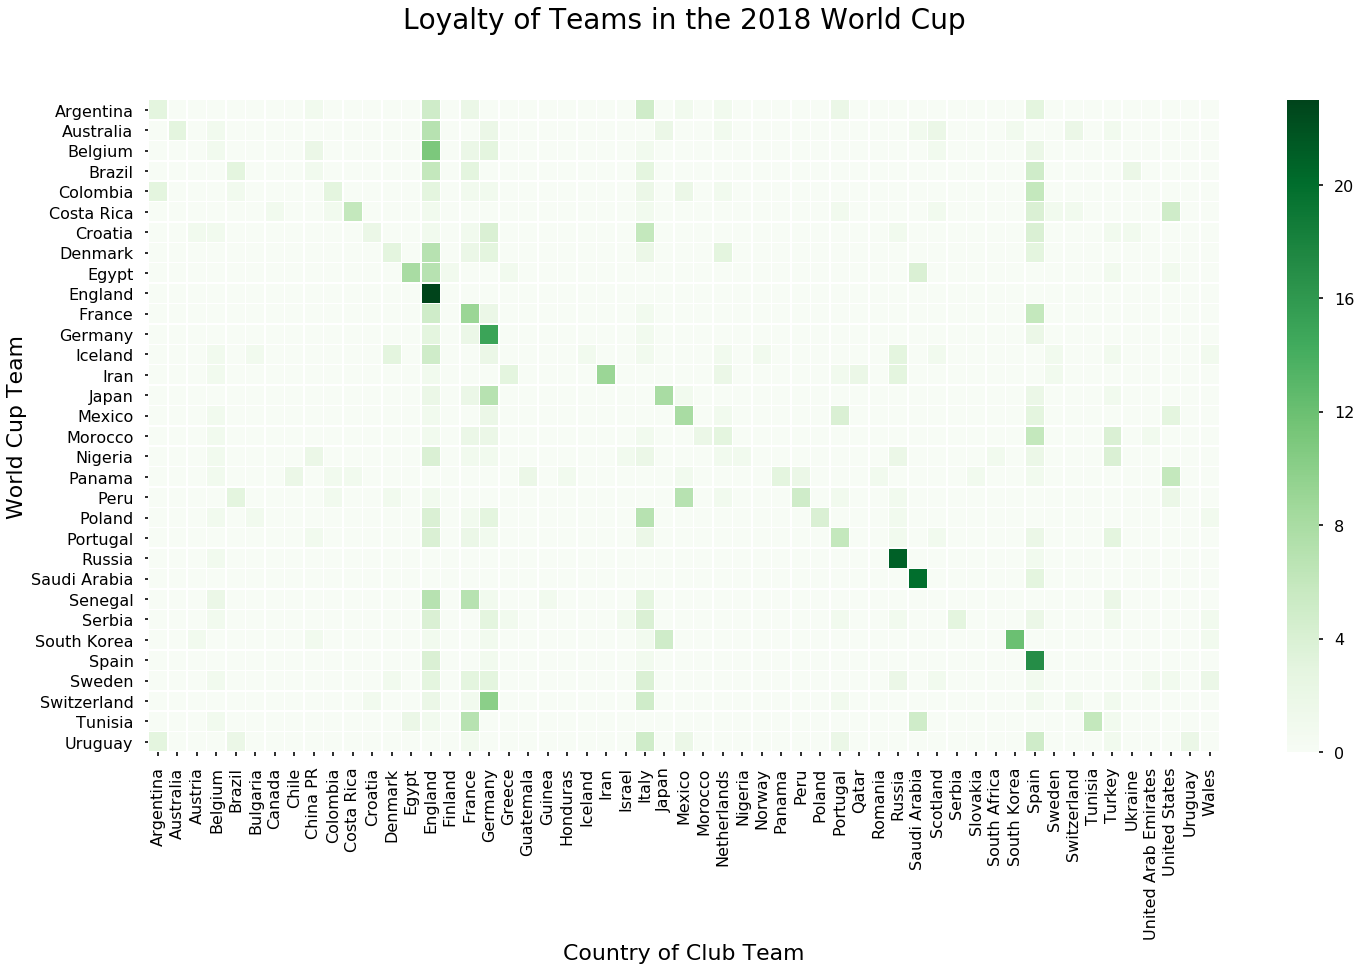

In [26]:
sns.set_context("poster")
fig = plt.figure(figsize=(24,12))
r = sns.heatmap(df_loyal, cmap='Greens',linewidths=.5)
r.set_xlabel("Country of Club Team", fontsize=22)
r.set_ylabel("World Cup Team", fontsize=22)
r.set_title("Loyalty of Teams in the 2018 World Cup", fontsize=28, y=1.1)
r.legend(loc="upper right", bbox_to_anchor=(1.15, 1.10), title="# of Loyal Players")

plt.show()
r = r.get_figure()
r.savefig(LoyaltyHeatmap)

### Insights
+ Players tend to gravitate to the major clubs in Europe (England, France, Germany, Italy, Spain)
     + (Observed by the vertical bands)
     + The listed European leagues have the most competative teams and money availible for premier players
     
+ Or they play in their home country
    + (Observed on the main Diagonal) 
 
+ The most loyal countries are England (100% loyalty rate), Russia and Saudi Arabia

## 4. Map wins on world map 

### Generate new value for Top 3 finishes

In [27]:
df[['Num_Wins', 'Num_2nd', 'Num_3rd']] = df[['Num_Wins', 'Num_2nd', 'Num_3rd']].apply(pd.to_numeric)
df['Top_3_Finishes'] = df['Num_Wins']+df['Num_2nd']+df['Num_3rd']

### Import Country Codes to fill out World Map

In [28]:
worlddf = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
worlddf.head(2)

,COUNTRY,GDP (BILLIONS),CODE
0,Afghanistan,21.71,AFG
1,Albania,13.40,ALB


### Addressing United Kingdom vs. England discrepency in the data

In [29]:
UKdf = pd.DataFrame({'COUNTRY': ['England'],
              'GDP (BILLIONS)': ['2848.00'],
              'CODE': ['GBR']})
worlddf = UKdf.append(worlddf)
worldcodes = pd.merge(df, worlddf, left_on='Team', right_on='COUNTRY', how='right')

In [30]:
data = [dict(
        type = 'choropleth',
        locations = worldcodes['CODE'],
        z = worldcodes['Top_3_Finishes'].dropna(axis=0, how='any'),
        text = worldcodes['COUNTRY'],
        colorscale=[[0.0, '#182D30'], [0.1111111111111111, '#284B50'],
                    [0.2222222222222222, '#396971'],[0.3333333333333333, '#498791'],
                    [0.4444444444444444, '#58A4B0'],[0.5555555555555556, '#76B4BE'],
                    [0.6666666666666666, '#94C5CC'],[0.7777777777777778, '#A3CDD3'],
                    [0.8888888888888888, '#C2DDE2'], [1.0, '#EFF6F7']],
        reversescale = True,
        marker = dict(
                line = dict(
                    color = 'rgb(180,180,180)',
                    width = 0.5)),
        colorbar = dict(
            autotick = False,
            title = '# of Top 3 finishes'))]

layout = dict(
        title = '# of Top 3 Finishes (Historical) for Countries in the 2018 World Cup',
        geo = dict(
            showframe = True,
            showcoastlines = True,
            projection = dict(type = 'Mercator')))

fig = dict(data=data, layout=layout )
iplot(fig, validate=False, filename='WC Top 3 Finishes, World Map' )

### Insights
+ Without knowing anything about the 2018 teams, one can expect Germany, Brazil, Argentina, or France to do well as they are historically dominant
+ Most teams that qualified for the 2018 World Cup have never placed in the top 3

## Part 3: Next Steps
#### 1. Compare the number of fans to performance of team 
#### 2. Look at host countries and their performance when they are hosting vs not
#### 3. Look into the details of performance per game by country
#### 4. Compare coaches of successful teams
#### 5. Create Sankey diagram with flow from World Cup team to various club teams